# Use pretrained models of scVI-hub for CELLxGENE

This notebook was contributed by Can Ergen and Martin Kim.

Original article:
`Scvi-hub: an actionable repository for model-driven single cell analysis`

https://www.biorxiv.org/content/10.1101/2024.03.01.582887

The anndata object we're using here is a subset of the full CELLxGENE census data. Use: s3://cellxgene-contrib-public/models/scvi/2024-02-12/mus_musculus/adata_minified.h5ad

**Steps performed**:

1. Loading the minified data from AWS
2. Setting up minified model with minified data
3. Visualize the latent space
4. Perform differential expression and visualize with interactive volcano plot and heatmap using Plotly

This notebook was designed to be run in Google Colab.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
!pip install --quiet cellxgene-census
!pip install --quiet pybiomart
from scvi_colab import install

install()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.35.24 requires botocore<1.36.0,>=1.35.24, but you have botocore 1.35.23 which is incompatible.
spatialdata 0.2.2 requires fsspec<=2023.6, but you have fsspec 2024.9.0 which is incompatible.


/usr/local/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import botocore
import cellxgene_census
import numpy as np
import plotnine as p9
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.hub import HubModel

/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:388: SyntaxWarning: invalid escape sequence '\m'
/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:761: SyntaxWarning: invalid escape sequence '\m'
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:7: SyntaxWarning: invalid escape sequence '\g'
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:305: SyntaxWarning: invalid escape sequence '\s'


/usr/local/lib/python3.12/site-packages/pyro/ops/stats.py:514: SyntaxWarning: invalid escape sequence '\g'


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.6


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

We download a toy example here (all cells from the spinal cord). To download the full census use backup_url: https://cellxgene-contrib-public.s3.amazonaws.com/models/scvi/2024-02-12/homo_sapiens/adata_minified.h5ad. Expect that the download of the full census takes ~30 minutes with a high bandwidth internet connection.

We share models for mouse at https://cellxgene-contrib-public.s3.amazonaws.com/models/scvi/2024-02-12/mus_musculus (same folder structure).

In [5]:
adata_path = os.path.join(save_dir.name, "adata-spinal-cord-minified.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://cellxgene-contrib-public.s3.amazonaws.com/models/scvi/2024-02-12/homo_sapiens/adata-spinal-cord-minified.h5ad",
)

model = HubModel.pull_from_s3(
    s3_bucket="cellxgene-contrib-public",
    s3_path="models/scvi/2024-02-12/homo_sapiens/modelhub",
    pull_anndata=False,
    config=botocore.config.Config(signature_version=botocore.UNSIGNED),
)

adata, model

  0%|          | 0.00/45.1M [00:00<?, ?B/s]

HubModel with:
local_dir: /tmp/tmp3gyd_s7l
model loaded? No
adata loaded? No
large_training_adata loaded? No
metadata:
HubMetadata(scvi_version='1.0.4', anndata_version='0.8.0', model_cls_name='SCVI', training_data_url=None, model_parent_module='scvi.model')
model_card:


───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
library_name: scvi-tools                                                                                           

license: cc-by-4.0                                                                                                 

tags:                                                                                                              

 • biology                                                                                                         
 • genomics                                                                                                        
 • single-cell                                                                                                     
 • model_cls_name:SCVI                                                                                             
 • scvi_version:1.0.4                                                                                              
 • anndata_version:0.8.0                                                                                           

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                   Description                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

SCVI model trained on the homo_sapiens data of the CELLxGENE Discover Census.                                      

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                Model properties                                                 ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

Many model properties are in the model tags. Some more are listed below.                                           

model_init_params:                                                                                                 

                                                                                                                   
                                                                                                                   
 {                                                                                                                 
                                                                                                                   
     "n_hidden": 128,                                                                                              
                                                                                                                   
     "n_latent": 50,                                                                                               
                                                                                                                   
     "n_layers": 2,                                                                                                
                                                                                                                   
     "dropout_rate": 0.1,                                                                                          
                                                                                                                   
     "dispersion": "gene",                                                                                         
                                                                                                                   
     "gene_likelihood": "nb",                  

(AnnData object with n_obs × n_vars = 117463 × 8000
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_observed_lib_size'
     var: 'soma_joinid', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
     uns: '_scvi_adata_minify_type', '_scvi_manager_uuid', '_scvi_uuid'
     obsm: '_scvi_latent_qzm', '_scvi_latent_qzv',
 )

### Setup minified model

Census was trained on all primary cells. We don't encode covariates so inference and generating latent codes works without retraining on these batches. We have to subset to all training batches.
The setup will be optimized in a future version of scvi-tools.

In [6]:
del adata.uns["_scvi_adata_minify_type"]
model.load_model(adata=adata[adata.obs["is_primary_data"]].copy())
census_model = model.model

INFO     Loading model...                                                                                          


INFO     File /tmp/tmp3gyd_s7l/model.pt already downloaded                                                         


/usr/local/lib/python3.12/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


/usr/local/lib/python3.12/site-packages/scvi/model/_scvi.py:168: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`


In [7]:
census_model_all = scvi.model.SCVI.load_query_data(adata, census_model)

/usr/local/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:224: UserWarning: Category 6006 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
/usr/local/lib/python3.12/site-packages/scvi/model/_scvi.py:168: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`


For spinal cord less than a half of cells is labeled as primary cells, while the other cells are duplicated from this dataset. census_model_all contains all cells while census_model only contains primary cells.

In [8]:
adata.obs["is_primary_data"].value_counts()

is_primary_data
False    67707
True     49756
Name: count, dtype: int64

In [9]:
census_model.adata, census_model_all.adata

(AnnData object with n_obs × n_vars = 49756 × 8000
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_observed_lib_size'
     var: 'soma_joinid', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
     uns: '_scvi_manager_uuid', '_scvi_uuid'
     obsm: '_scvi_latent_qzm', '_scvi_latent_qzv',
 AnnData object with n_obs × n_vars = 117463 × 8000
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'deve

By default scvi-tools loads models as not minified. We set up the model here with minified data, so we minify the model using the respective obsm fields.

In [10]:
census_model.minify_adata(
    use_latent_qzm_key="_scvi_latent_qzm", use_latent_qzv_key="_scvi_latent_qzv"
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


INFO     Generating sequential column names                                                                        


INFO     Generating sequential column names                                                                        


### Get the latent space and compute UMAP

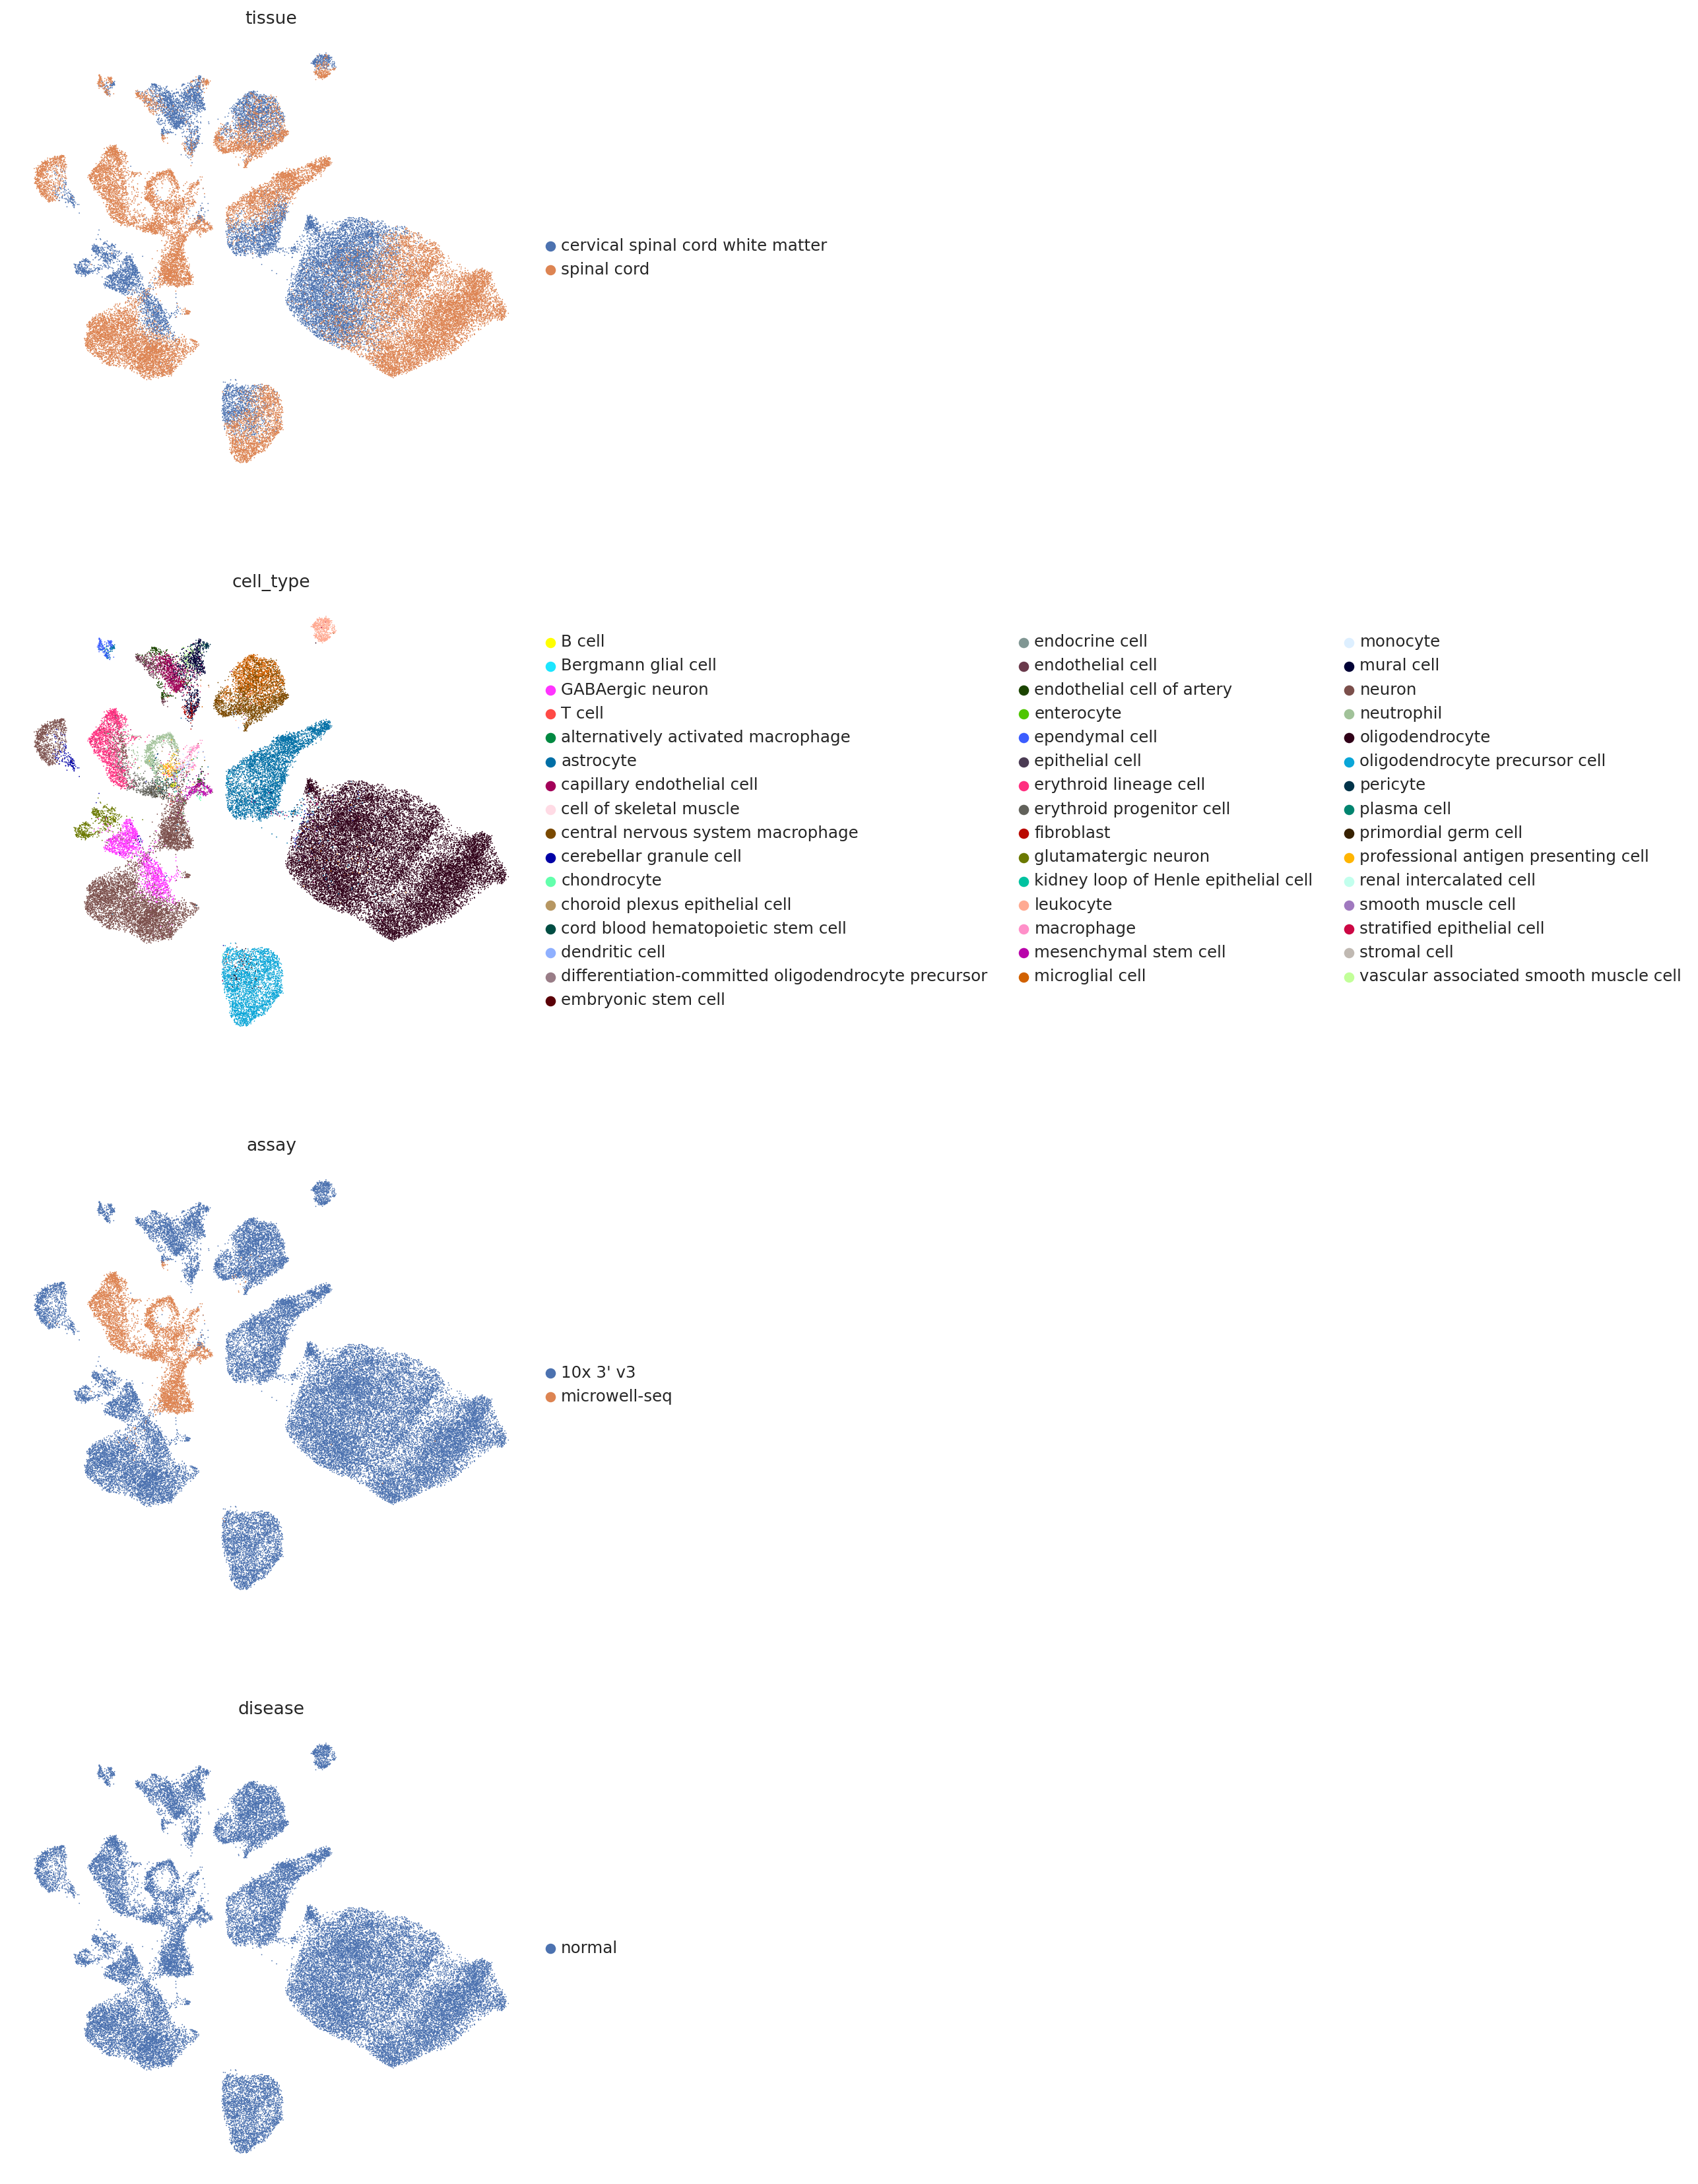

In [11]:
sc.pp.neighbors(census_model.adata, n_neighbors=20, use_rep="_scvi_latent_qzm")
sc.tl.umap(census_model.adata)
sc.pl.umap(census_model.adata, color=["tissue", "cell_type", "assay", "disease"], ncols=1)

## Performing Differential Expression in scVI

While we only have access to the minified data, we can still perform downstream analysis using the generative part of the model.

Differential expression (DE) analysis is used to quantify the differences in gene expression across subpopulations of genes.
If we have two sets of cells $A$ and $B$, a DE test is typically used to predict two things for each gene:

1. Whether the gene's expression levels are significantly different in the A and B sets of cells.
2. An effect size that quantifies the strength of the differential expression.

Once trained, scVI can natively perform both of these tasks.
Additionally, its differential expression module can account for batch effects and filter DE genes expected to be of little relevance.

### Selecting cell subpopulations to compare

In [12]:
# let's take a look at abundances of different cell types
print(
    census_model.adata.obs["cell_type"].value_counts(),
    "\n\n\n\n",
    census_model.adata.obs["tissue"].value_counts(),
)

cell_type
oligodendrocyte                                        20708
neuron                                                  7831
astrocyte                                               4449
oligodendrocyte precursor cell                          3191
microglial cell                                         1864
GABAergic neuron                                        1790
central nervous system macrophage                       1777
erythroid lineage cell                                  1684
capillary endothelial cell                               915
mural cell                                               879
neutrophil                                               708
erythroid progenitor cell                                606
glutamatergic neuron                                     576
leukocyte                                                542
endothelial cell of artery                               330
endothelial cell                                         247
mesenchymal st

scVI provides several options to identify the two populations of interest.

In [13]:
cell_type = "oligodendrocyte"
tissue1 = "spinal cord"
cell_idx1 = np.logical_and(
    census_model.adata.obs["cell_type"] == cell_type,
    census_model.adata.obs["tissue"] == tissue1,
)
print(sum(cell_idx1), "cells from tissue", tissue1)

tissue2 = "cervical spinal cord white matter"
cell_idx2 = np.logical_and(
    census_model.adata.obs["cell_type"] == cell_type,
    census_model.adata.obs["tissue"] == tissue2,
)
print(sum(cell_idx2), "cells of type", tissue2)

# or equivalently, provide a string of the form "my_celltype_column == 'desired_celltype'"
# cell_idx1 = "cell_type == 'Ciliated_non_amphid_neuron'"
# cell_idx2 = "cell_type == 'Intestine'"

11547 cells from tissue spinal cord
9161 cells of type cervical spinal cord white matter


### Running DE analyses

A simple DE analysis can then be performed using the following command

In [14]:
de_change = census_model.differential_expression(idx1=cell_idx1, idx2=cell_idx2, all_stats=False)

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

This method returns a pandas DataFrame, where each row corresponds to a gene.
The most important columns of this dataframe are the following.
**proba_de**, which captures the posterior probability of $M_{2, g}$ that the gene is differentially expressed. Values close to one indicate that the gene is DE;
**lfc_mean** and **lfc_median**, respectively denoting the mean and the median of the posterior distribution of $\beta_g$. Positive values of the LFC signify that the gene is upregulated in `idx1`;
**is_de_fdr_0.05** is `True` when the gene is tagged DE after FDR correction at target level $\alpha=0.05$. The target level can be adjusted by specifying `fdr_target` in the `differential_expression` method.

### Volcano plot with p-values

In [15]:
de_change["log10_pscore"] = np.log10(de_change["proba_not_de"] + 1e-6)
de_change = de_change.join(census_model.adata.var, how="inner")
de_change = de_change.loc[np.max(de_change[["scale1", "scale2"]], axis=1) > 1e-4]
de_change["feature_id"] = de_change.index
de_change.index = de_change["feature_name"]
de_change.head(20)

proba_de  proba_not_de  bayes_factor        scale1  \
feature_name                                                        
PRKCQ-AS1           1.0           0.0     18.420681  1.230528e-04   
PLCG2               1.0           0.0     18.420681  1.080190e-05   
RPL17               1.0           0.0     18.420681  1.755241e-04   
RPL32P3             1.0           0.0     18.420681  1.699188e-04   
RPS10               1.0           0.0     18.420681  1.555399e-04   
RWDD3               1.0           0.0     18.420681  1.028030e-04   
SGO1-AS1            1.0           0.0     18.420681  1.176230e-04   
SLC26A3             1.0           0.0     18.420681  1.699776e-05   
SOX2                1.0           0.0     18.420681  3.380096e-06   
SOX2-OT             1.0           0.0     18.420681  4.394894e-03   
MRPS31P5            1.0           0.0     18.420681  1.028728e-04   
STX16               1.0           0.0     18.420681  1.538485e-04   
UBE2V1              1.0           0.0     18.420681  1.391584e-04   
ZC3H11A             1.0           0.0     18.420681  4.547413e-04   
RP11-13A2.5         1.0           0.0     18.420681  2.150162e-04   
ZNF56               1.0           0.0     18.420681  2.483926e-04   
MIR100HG            1.0           0.0     18.420681  2.157415e-03   
RP11-326E22.2       1.0           0.0     18.420681  2.032912e-04   
MAGI2-AS3           1.0           0.0     18.420681  4.456284e-04   
MTRNR2L12           1.0           0.0     18.420681  2.134031e-07   

                     scale2  pseudocounts  delta   lfc_mean  lfc_median  \
feature_name                                                              
PRKCQ-AS1      6.122091e-06           0.0   0.25   4.234055    4.235188   
PLCG2          1.328016e-04           0.0   0.25  -3.573616   -3.575109   
RPL17          5.781009e-06           0.0   0.25   4.930901    4.978129   
RPL32P3        1.112937e-07           0.0   0.25  10.732672   10.726068   
RPS10          5.756226e-06           0.0   0.25   4.850702    4.882492   
RWDD3          9.010642e-06           0.0   0.25   3.540111    3.550129   
SGO1-AS1       1.214340e-06           0.0   0.25   6.705634    6.654238   
SLC26A3        6.341395e-04           0.0   0.25  -5.116875   -5.147023   
SOX2           1.133860e-04           0.0   0.25  -5.052306   -5.042466   
SOX2-OT        7.167412e-07           0.0   0.25  12.822459   12.835955   
MRPS31P5       9.419149e-08           0.0   0.25  10.207337   10.179218   
STX16          6.493473e-05           0.0   0.25   1.271160    1.253100   
UBE2V1         8.504647e-06           0.0   0.25   4.084114    4.086703   
ZC3H11A        1.021843e-04           0.0   0.25   2.191399    2.144897   
RP11-13A2.5    4.361469e-07           0.0   0.25   9.070029    9.006927   
ZNF56          1.220145e-07           0.0   0.25  11.129900   11.136563   
MIR100HG       2.144368e-05           0.0   0.25   6.733043    6.718174   
RP11-326E22.2  5.628331e-07           0.0   0.25   8.620193    8.649633   
MAGI2-AS3      2.454530e-07           0.0   0.25  11.037951   11.028957   
MTRNR2L12      1.378079e-04           0.0   0.25  -9.673280   -9.739614   

                lfc_std    lfc_min    lfc_max  is_de_fdr_0.05  log10_pscore  \
feature_name                                                                  
PRKCQ-AS1      0.961707   0.672802   8.398901            True          -6.0   
PLCG2          0.880594  -6.409345  -0.501044            True          -6.0   
RPL17          1.116411   1.120990   8.368684            True          -6.0   
RPL32P3        0.735848   8.573318  13.043948            True          -6.0   
RPS10          1.267890   0.591713   8.893880            True          -6.0   
RWDD3          0.340671   2.308668   4.649152            True          -6.0   
SGO1-AS1       0.730793   4.400548   9.642642            True          -6.0   
SLC26A3        0.758414  -7.547303  -2.231958            True          -6.0   
SOX2           0.510457  -7.003593  -3.061825          

In [16]:
gene_annotations = sc.queries.biomart_annotations(
    org="hsapiens",
    attrs=["ensembl_gene_id", "gene_biotype"],
)

In [17]:
gene_annotations.index = gene_annotations["ensembl_gene_id"]
gene_annotation_dict = gene_annotations["gene_biotype"].to_dict()
de_change["Biotype"] = [
    gene_annotation_dict.pop(i, "Unannotated") for i in de_change["feature_id"]
]
de_change["Biotype"].value_counts()

Biotype
protein_coding                        814
lncRNA                                 71
transcribed_unprocessed_pseudogene      7
Unannotated                             3
Mt_rRNA                                 2
transcribed_unitary_pseudogene          1
Name: count, dtype: int64

/usr/local/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 13 rows containing missing values.


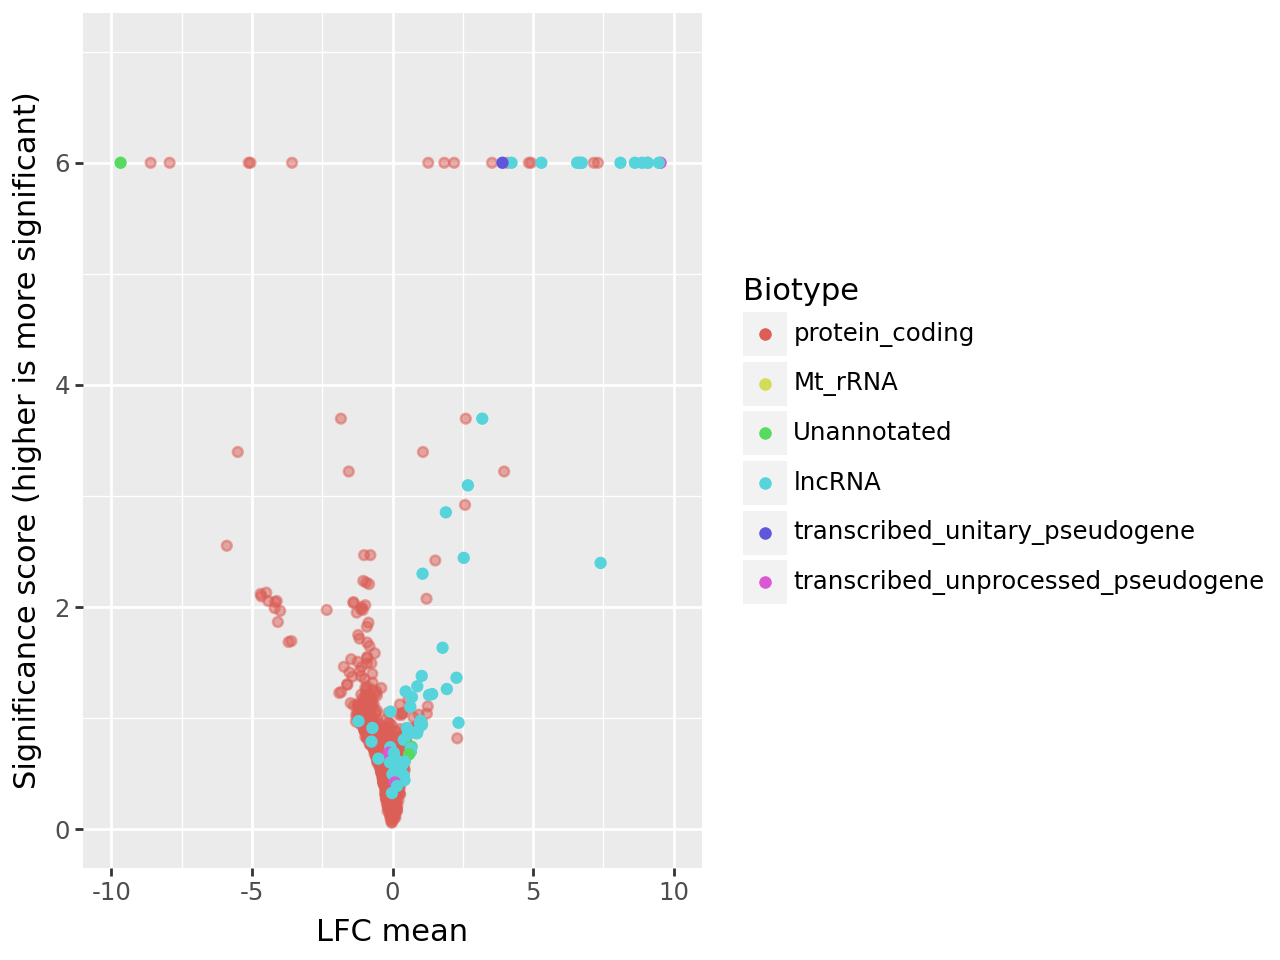

In [18]:
(
    p9.ggplot(de_change, p9.aes("lfc_mean", "-log10_pscore", color="Biotype"))
    + p9.geom_point(
        de_change.query("Biotype == 'protein_coding'"), alpha=0.5
    )  # Plot other genes with transparence
    + p9.xlim(-10, 10)  # Set x limits
    + p9.ylim(0, 7)  # Set y limits
    + p9.geom_point(de_change.query("Biotype != 'protein_coding'"))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
)

In [19]:
upregulated_genes = de_change.loc[
    de_change["lfc_median"] > 0, ["feature_id", "feature_name"]
].head(4)

Display generated counts from scVI model

/usr/local/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.


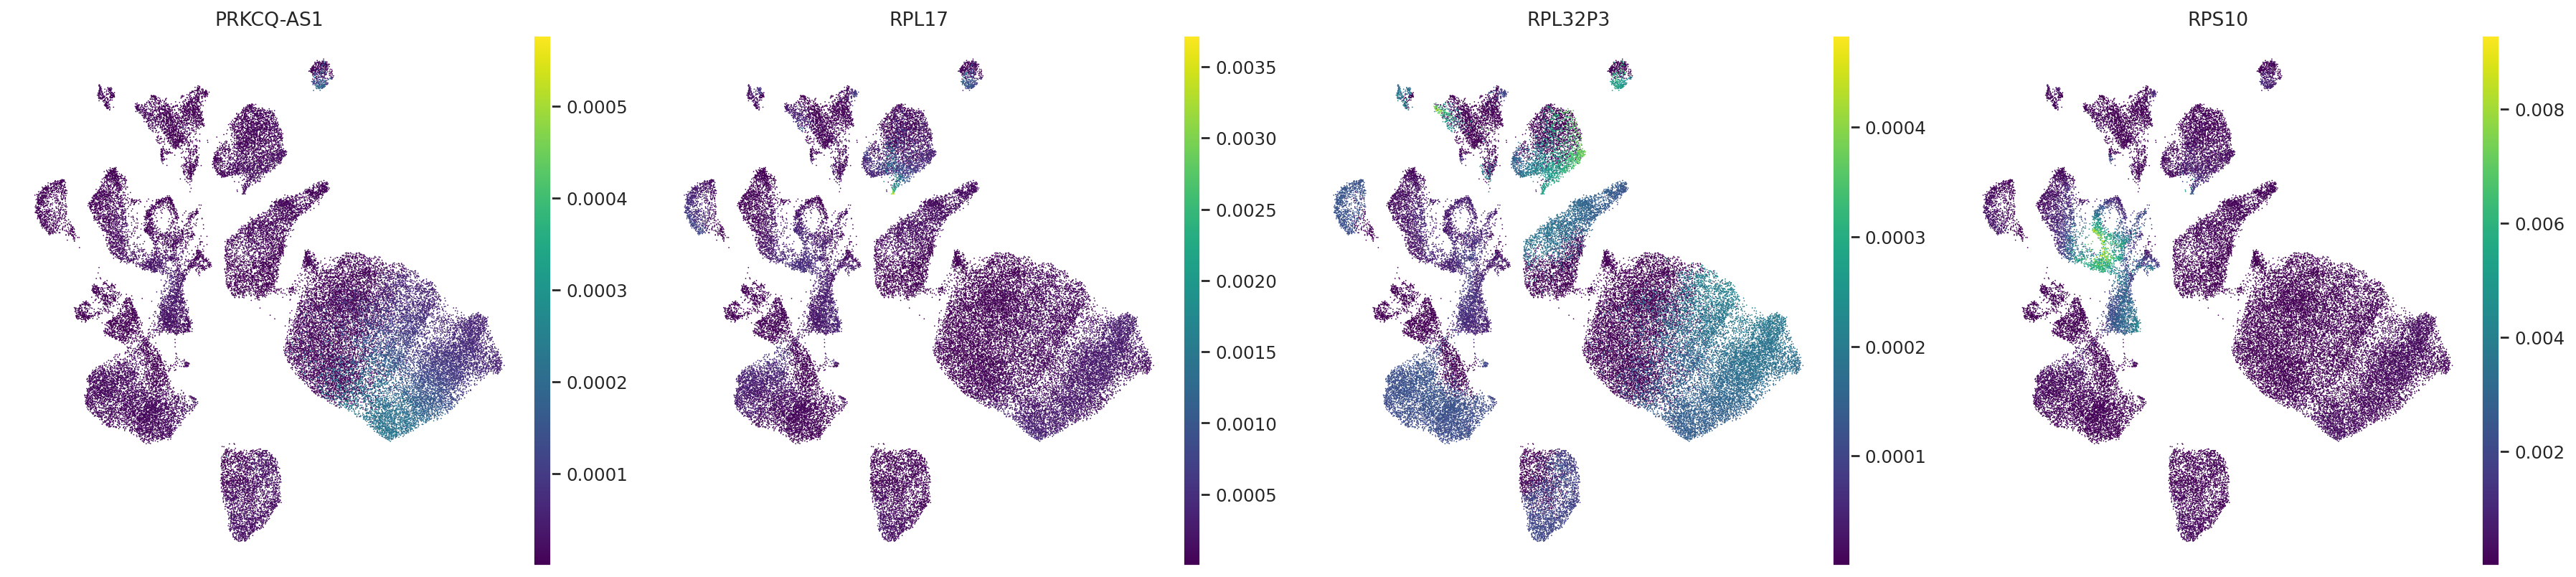

In [20]:
census_model.adata[:, upregulated_genes["feature_id"]] = census_model.get_normalized_expression(
    gene_list=list(upregulated_genes["feature_id"]), n_samples=10
)
sc.pl.umap(
    census_model.adata,
    color=upregulated_genes["feature_name"],
    gene_symbols="feature_name",
    cmap="viridis",
)

## Performing differential expression and yield expression from census

Now we perform DE between each cell type vs all other cells and make a dotplot of the result.

#### Performing differential expression

In [21]:
# here we do a 1-vs-all DE test, which compares each cell type with all others
# this returns the concatenation of all 1 vs all results, contained in a DataFrame
change_per_cluster_de = census_model.differential_expression(
    adata=census_model.adata[census_model.adata.obs["assay"] == "10x 3' v3"],
    groupby="cell_type",
    all_stats=False,
)

INFO     Received view of anndata, making copy.                                                                    


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?


DE...:   0%|          | 0/21 [00:00<?, ?it/s]

In [22]:
cell_types = (
    adata.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [23]:
change_per_cluster_de = change_per_cluster_de.join(census_model.adata.var, how="inner")
change_per_cluster_de = change_per_cluster_de[
    change_per_cluster_de[["scale1", "scale2"]].max(axis=1) > 1e-4
]
change_per_cluster_de.head(20)

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
feature_id                                                                  
ENSG00000287372    0.9966        0.0034      5.680571  0.000352  0.000053   
ENSG00000287544    0.9954        0.0046      5.377086  0.000312  0.000013   
ENSG00000125968    0.9932        0.0068      4.984008  0.000126  0.000137   
ENSG00000163453    0.9932        0.0068      4.984008  0.000474  0.000444   
ENSG00000172201    0.9928        0.0072      4.926447  0.000633  0.000193   
ENSG00000271945    0.9928        0.0072      4.926447  0.000317  0.000081   
ENSG00000283380    0.9926        0.0074      4.898846  0.000242  0.000033   
ENSG00000041982    0.9924        0.0076      4.871977  0.001716  0.000522   
ENSG00000286133    0.9920        0.0080      4.820280  0.000250  0.000028   
ENSG00000182492    0.9918        0.0082      4.795386  0.000027  0.000164   
ENSG00000286749    0.9914        0.0086      4.747355  0.000057  0.001011   
ENSG00000167772    0.9912        0.0088      4.724163  0.000350  0.000129   
ENSG00000117318    0.9904        0.0096      4.636345  0.000198  0.000205   
ENSG00000185650    0.9900        0.0100      4.595119  0.000810  0.000711   
ENSG00000154175    0.9894        0.0106      4.536244  0.000378  0.000123   
ENSG00000114315    0.9892        0.0108      4.517349  0.000174  0.000104   
ENSG00000080493    0.9890        0.0110      4.498798  0.003841  0.000305   
ENSG00000231427    0.9890        0.0110      4.498798  0.000011  0.000209   
ENSG00000074410    0.9886        0.0114      4.462676  0.000243  0.000063   
ENSG00000204929    0.9884        0.0116      4.445082  0.000940  0.000112   

                 pseudocounts  delta   lfc_mean  lfc_median   lfc_std  ...  \
feature_id                                                             ...   
ENSG00000287372           0.0   0.25  10.098774    9.726233  4.152241  ...   
ENSG00000287544           0.0   0.25   9.761824    8.134218  4.613431  ...   
ENSG00000125968           0.0   0.25   3.457879    4.233216  3.074085  ...   
ENSG00000163453           0.0   0.25   3.567271    4.429197  2.611707  ...   
ENSG00000172201           0.0   0.25   5.217178    5.938439  2.980853  ...   
ENSG00000271945           0.0   0.25   6.255356    5.814308  4.282311  ...   
ENSG00000283380           0.0   0.25   7.731935    7.162708  4.517736  ...   
ENSG00000041982           0.0   0.25   6.446057    7.178648  3.019589  ...   
ENSG00000286133           0.0   0.25   7.234351    6.476529  3.618663  ...   
ENSG00000182492           0.0   0.25   3.659565    4.861273  4.252452  ...   
ENSG00000286749           0.0   0.25   2.216055    1.884742  6.936182  ...   
ENSG00000167772           0.0   0.25   4.048803    4.234704  2.688754  ...   
ENSG00000117318           0.0   0.25   2.890789    3.181549  3.075953  ...   
ENSG00000185650           0.0   0.25   3.651941    5.341339  3.379040  ...   
ENSG00000154175           0.0   0.25   3.347516    3.957913  1.896013  ...   
ENSG00000114315           0.0   0.25   4.290458    5.222503  3.255705  ...   
ENSG00000080493           0.0   0.25   6.003542    6.863938  2.503586  ...   
ENSG00000231427           0.0   0.25  -0.748589    0.257591  4.291699  ...   
ENSG00000074410           0.0   0.25   4.959381    5.567525  2.714884  ...   
ENSG00000204929           0.0   0.25   4.645700    4.434205  2.387054  ...   

                   lfc_max  is_de_fdr_0.05                   comparison  \
feature_id                                                                
ENSG00000287372  17.578503            True  Bergmann glial cell vs Rest   
ENSG00000287544  20.266708            True  Bergmann glial cell vs Rest   
ENSG00000125968  10.953665            True  Bergmann glial cell vs Rest   
ENSG00000163453   9.524614            True  Bergmann glial cell vs Rest   
ENSG00000172201  10.261541            True  Bergmann glial cell vs Rest   
ENSG00000271945  15.188108            True  Bergmann glial cell vs Rest   
ENSG0

In [24]:
# This cell extracts list of top 5 upregulated genes for every cell-type
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:5]
    )  # Select top 5 DE genes per comparison
    .reset_index(drop=True)[["feature_name", "soma_joinid"]]
    .drop_duplicates()
)

/tmp/ipykernel_154/3989176659.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


### Download raw counts for these genes from CELLxGENE census

We can download the raw expression only for cells and genes of interest from CELLxGENE census. This drastically improves runtime. It is important to use the same census version used for training the model

In [25]:
census = cellxgene_census.open_soma(census_version="2023-12-15")

In [26]:
# This cell extracts list of top 5 upregulated genes for every cell-type
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:5]
    )  # Select top 5 DE genes per comparison
    .reset_index(drop=True)[["feature_name", "soma_joinid"]]
    .drop_duplicates()
)

/tmp/ipykernel_154/3989176659.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [27]:
adata = cellxgene_census.get_anndata(
    census=census,
    organism="Homo sapiens",
    var_coords=marker_genes["soma_joinid"].to_list(),
    obs_coords=census_model.adata.obs.loc[
        census_model.adata.obs["assay"] == "10x 3' v3", "soma_joinid"
    ].to_list(),
    column_names={
        "obs": [
            "soma_joinid",
            "dataset_id",
            "assay",
            "cell_type",
            "disease",
            "donor_id",
            "observation_joinid",
            "sex",
            "suspension_type",
            "tissue",
            "raw_sum",
            "nnz",
            "raw_mean_nnz",
            "raw_variance_nnz",
            "n_measured_vars",
        ]
    },
)

/tmp/ipykernel_154/854037560.py:1: FutureWarning: The argument `column_names` is deprecated and will be removed in a future release. Please use `obs_column_names` and `var_column_names` instead.


[2024-09-22 12:28:20.596] [tiledbsoma] [Process: 154] [Thread: 2320] [warning] [TileDB-SOMA::ManagedQuery] [obs] Invalid column selected: observation_joinid


#### Confirm results of downloading cells and dotplot

Check that census download yields the same cells

In [28]:
adata.var.index = adata.var["feature_id"]

In [29]:
np.all(
    adata.obs["dataset_id"].values
    == census_model.adata.obs.loc[census_model.adata.obs["assay"] == "10x 3' v3", "dataset_id"]
)

True

/usr/local/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts


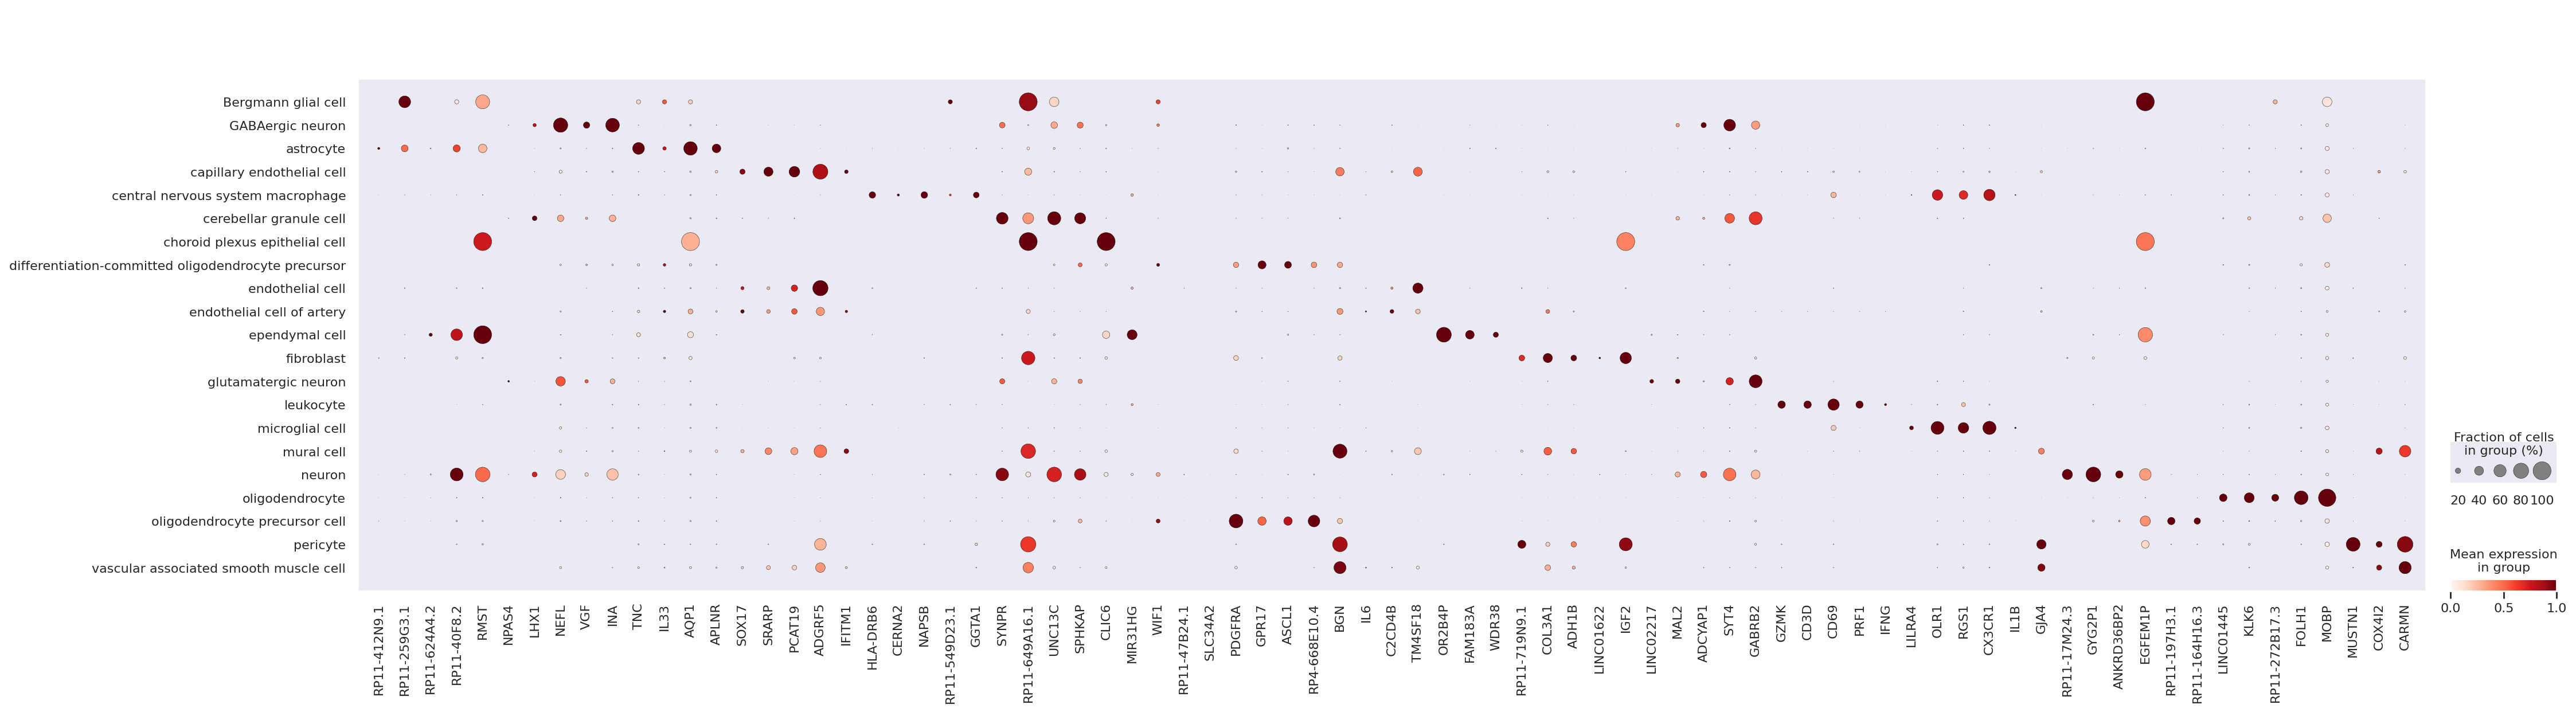

In [30]:
adata_log = adata[adata.obs.cell_type.isin(cell_types.index.values)].copy()
sc.pp.normalize_total(adata_log)
sc.pp.log1p(adata_log)
sc.pl.dotplot(
    adata_log,
    marker_genes["feature_name"].to_list(),
    groupby="cell_type",
    gene_symbols="feature_name",
    standard_scale="var",
)